In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

### Quantum Fourier Transform (QFT)

In [2]:
def qft_circuit(n_qubits):
    for i in range(n_qubits):
        # Apply Hadamard gate
        qml.Hadamard(wires=i)
        # Apply controlled rotations
        for j in range(i+1, n_qubits):
            angle = np.pi / 2**(j-i)
            qml.ControlledPhaseShift(angle, wires=[j, i])

    # Swap qubits to reverse order
    for i in range(n_qubits // 2):
        qml.SWAP(wires=[i, n_qubits-i-1])

0: ──H─╭Rϕ(1.57)─╭Rϕ(0.79)─╭Rϕ(0.39)─╭Rϕ(0.20)──────────────────────────────────────────────
1: ────╰●────────│─────────│─────────│──────────H─╭Rϕ(1.57)─╭Rϕ(0.79)─╭Rϕ(0.39)─────────────
2: ──────────────╰●────────│─────────│────────────╰●────────│─────────│──────────H─╭Rϕ(1.57)
3: ────────────────────────╰●────────│──────────────────────╰●────────│────────────╰●───────
4: ──────────────────────────────────╰●───────────────────────────────╰●────────────────────

────────────────────────────╭SWAP───────┤  State
────────────────────────────│─────╭SWAP─┤  State
──╭Rϕ(0.79)─────────────────│─────│─────┤  State
──│──────────H─╭Rϕ(1.57)────│─────╰SWAP─┤  State
──╰●───────────╰●─────────H─╰SWAP───────┤  State


(<Figure size 2000x600 with 1 Axes>, <Axes: >)

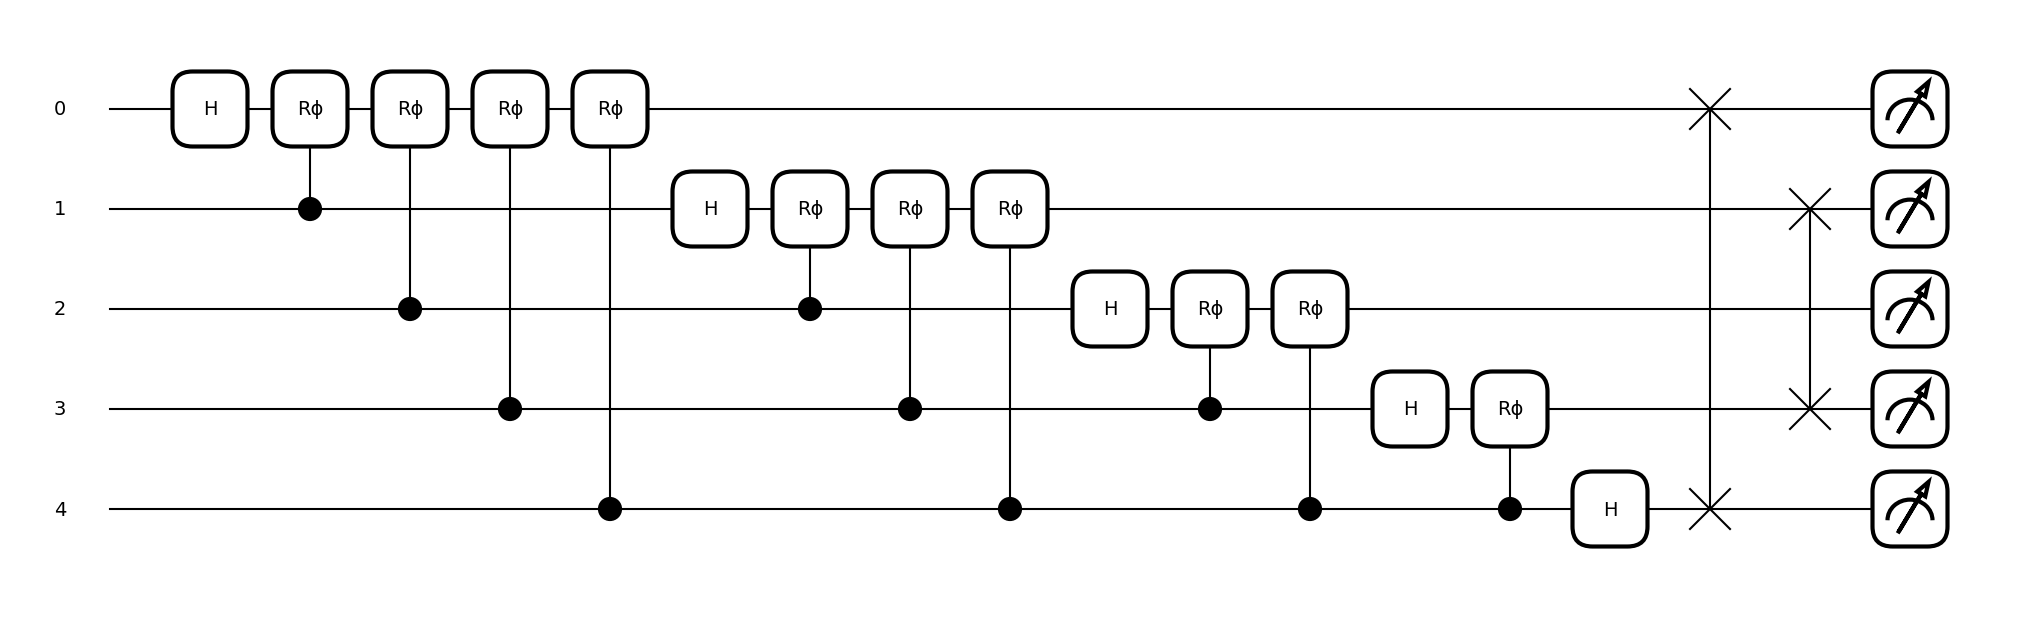

In [3]:
# Create a 5-qubit QFT circuit
qft_qubits = 5
dev = qml.device("default.qubit", wires=qft_qubits)

@qml.qnode(dev)
def qft_qnode():
    qft_circuit(qft_qubits)
    return qml.state()

# Draw the QFT circuit
drawer = qml.draw(qft_qnode)
print(drawer())

# Visualize the QFT circuit using matplotlib
qml.draw_mpl(qft_qnode)()

### QFT inspired Uniform Quantum Superposition (UQS) Circuit Construction for Arbitary Integer $N$

In [4]:
def powers_of_2(M):
    powers = []
    bit_position = 0
    while M > 0:
        if M & 1:
            powers.append(bit_position)
        M = M >> 1
        bit_position += 1
        
    return list(reversed(powers))

In [5]:
def RY_thetas(M):
    powers = powers_of_2(M)
    
    thetas = []
    current_sum = 0
    
    for p in (powers):
        if p == powers[-1]:
            break
        
        theta = 2*np.arctan(np.sqrt(2**p / (M - current_sum - 2**p)))
        
        thetas.append(theta)
        current_sum += 2**p
        
    return thetas, powers

In [6]:
def uqs(M):
    thetas, powers = RY_thetas(M)
    n_qubits = powers[0] + 1
    
    @qml.qnode(qml.device('default.qubit', wires=n_qubits))
    def circuit():
        
        for ry_target in range(len(thetas)):
            ry_control = list(range(ry_target))
            
            if ry_control:
                qml.ctrl(qml.RY, control=ry_control, control_values=[0] * len(ry_control))(thetas[ry_target], wires=ry_target)
            else:
                qml.RY(thetas[ry_target], wires=ry_target)
                
            
            for h_target in range(ry_target + 1, ry_target + 1 + powers[ry_target]):
                h_control = list(range(ry_target + 1))
                if h_control:
                    h_control_val = [0] * len(h_control)
                    h_control_val[-1] = 1
                    qml.ctrl(qml.Hadamard, control=h_control, control_values=h_control_val)(wires=h_target)
                        
        
        if powers[-1] != 0:
            for p in range(powers[-1]):
                qml.ctrl(qml.Hadamard, control=list(range(len(thetas))), control_values=[0] * len(thetas))(wires=len(thetas)+p)
                
        return qml.state()

    return circuit

0: ──H─╭Rϕ(1.57)─╭Rϕ(0.79)─╭Rϕ(0.39)─╭Rϕ(0.20)──────────────────────────────────────────────
1: ────╰●────────│─────────│─────────│──────────H─╭Rϕ(1.57)─╭Rϕ(0.79)─╭Rϕ(0.39)─────────────
2: ──────────────╰●────────│─────────│────────────╰●────────│─────────│──────────H─╭Rϕ(1.57)
3: ────────────────────────╰●────────│──────────────────────╰●────────│────────────╰●───────
4: ──────────────────────────────────╰●───────────────────────────────╰●────────────────────

────────────────────────────╭SWAP───────┤  State
────────────────────────────│─────╭SWAP─┤  State
──╭Rϕ(0.79)─────────────────│─────│─────┤  State
──│──────────H─╭Rϕ(1.57)────│─────╰SWAP─┤  State
──╰●───────────╰●─────────H─╰SWAP───────┤  State


(<Figure size 800x400 with 1 Axes>, <Axes: >)

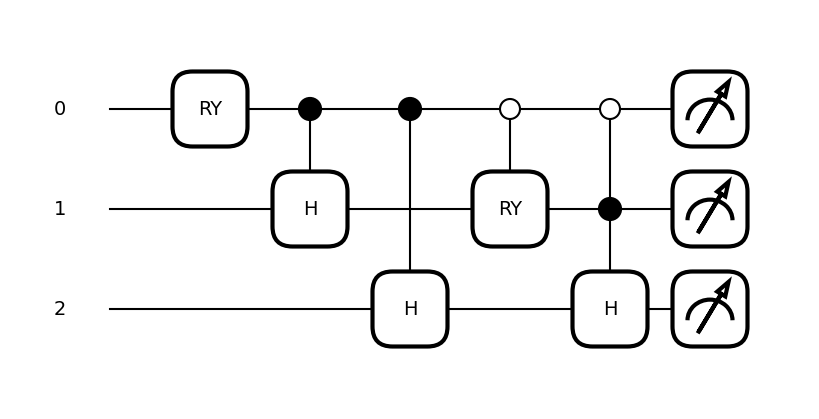

In [7]:
M = 7
thetas, powers = RY_thetas(M)
print(drawer())

uqs_circuit = uqs(M)
drawer = qml.draw(uqs_circuit)
qml.draw_mpl(uqs_circuit)()

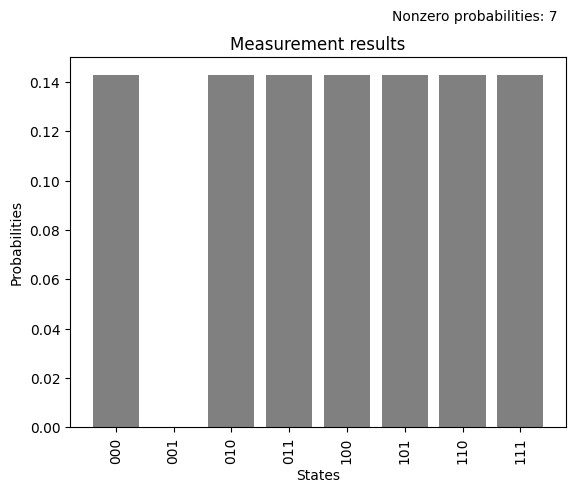

In [8]:
probability_amplitudes = uqs_circuit()
probabilities = np.abs(probability_amplitudes) ** 2

num_qubits = len(probabilities).bit_length() - 1

plt.bar(range(len(probabilities)), probabilities, color='gray')
plt.xlabel('States')
plt.ylabel('Probabilities')
plt.title('Measurement results')

plt.xticks(range(len(probabilities)), [f'{i:0{num_qubits}b}' for i in range(len(probabilities))], rotation=90)

nonzero_probabilities = np.count_nonzero(probabilities > 0)
plt.text(0.65, 1.1, f'Nonzero probabilities: {nonzero_probabilities}', transform=plt.gca().transAxes)

plt.show()

### UQS Circuit Construction w/o Multi-Qubit Control for Arbitary Integer $N$

In [9]:
def RY_eff_thetas(M):
    powers = powers_of_2(M)
    
    thetas = []
    current_sum = M
    
    for p in reversed(powers):
        if p == powers[0]:
            break
        current_sum -= 2**p
        print(current_sum)
        
        ratio = current_sum / (2**p)
        
        theta = 2*np.arctan(np.sqrt(ratio))
        thetas.append(theta)
        
    return thetas, powers

In [10]:
def uqs_efficient(M):
    
    counts = 0
    while M % 2 == 0:
        M //= 2
        counts += 1

    thetas, powers = RY_eff_thetas(M)
    
    if powers:
        n_qubits = powers[0] + 1 + counts
    else:
        n_qubits = counts
        
    @qml.qnode(qml.device('default.qubit', wires=n_qubits))
    def circuit():
    
        def A_gate(i, theta):
            qml.RY(theta, wires=i+1)
            qml.ctrl(qml.Hadamard, control=i+1, control_values=1)(wires=i)
    
        def B_gate(i, theta):
            qml.ctrl(qml.RY, control=i, control_values=1)(theta, wires=i+1)
            qml.ctrl(qml.Hadamard, control=i+1, control_values=1)(wires=i)
        
        def S_gate(i):
            qml.ctrl(qml.PauliX, control=i, control_values=1)(wires=i+1)
            qml.ctrl(qml.Hadamard, control=i+1, control_values=1)(wires=i)
        
        for i in range(counts):
            qml.Hadamard(wires=i)
            
        if M == 1:
            return qml.state()

        else:
            A_gate(counts, thetas[0])
            
            k = 1
            
            for j in range(1, powers[0]):
                if j in powers:
                    B_gate(counts + j, thetas[k])
                    k += 1

                else:
                    S_gate(counts+j)

            return qml.state()

    return circuit

12
8
0: ──H──────────────────────────────┤  State
1: ───────────╭H────────────────────┤  State
2: ──RY(2.58)─╰●─╭●─╭H──────────────┤  State
3: ──────────────╰X─╰●─╭●────────╭H─┤  State
4: ────────────────────╰RY(1.91)─╰●─┤  State


(<Figure size 900x600 with 1 Axes>, <Axes: >)

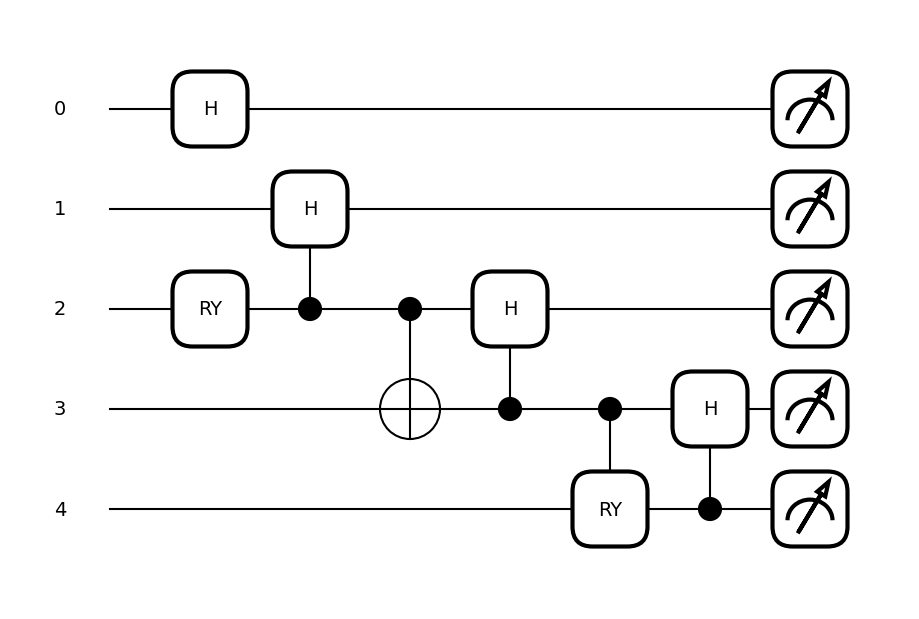

In [15]:
M = 26
uqs_eff_circuit = uqs_efficient(M)
drawer = qml.draw(uqs_eff_circuit)
print(drawer())
qml.draw_mpl(uqs_eff_circuit)()

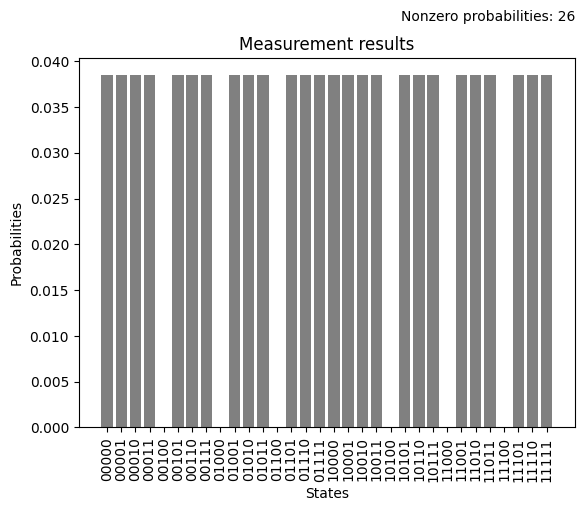

In [16]:
probability_amplitudes = uqs_eff_circuit()
probabilities = np.abs(probability_amplitudes) ** 2

# Get the number of qubits from the circuit
num_qubits = len(probabilities).bit_length() - 1  # The number of qubits used

# Plot the histogram of probabilities
plt.bar(range(len(probabilities)), probabilities, color='gray')
plt.xlabel('States')
plt.ylabel('Probabilities')
plt.title('Measurement results')

# Format the x-axis ticks to display binary state labels
plt.xticks(range(len(probabilities)), [f'{i:0{num_qubits}b}' for i in range(len(probabilities))], rotation=90)

# Count nonzero probabilities and display them on the plot
nonzero_probabilities = np.count_nonzero(probabilities > 0.0)
plt.text(0.65, 1.1, f'Nonzero probabilities: {nonzero_probabilities}', transform=plt.gca().transAxes)

# Show the plot
plt.show()